In [60]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os
import matplotlib
import igraph
from collections import Counter
import networkx as nx
from sklearn import preprocessing

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics
import seaborn as sns
from helpers.networks import *
import helpers.linkage as lkg
from helpers import style 

style.load_style()

cf = yaml.safe_load(Path('config.yml').read_text())

In [4]:
data = dataloader.load(cf,agg_level='speech',model_type='lda')
dists = data['dists']
labels = data['labels']
words = data['words']

dists = dists[(dists.index.year > 1945) & (dists.index.year < 1967)]

# Load merged cabinet metadata
cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

indices_nonsem = [k for k,v in labels.items() if 'rhet' in v or 'proc' in v]
labels_reverse =dict(zip(labels.values(),labels.keys()))

/tmp/ipykernel_4097/283382609.py:11: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)


# Plot top betweenness and degree scores on scatter

/tmp/ipykernel_1280/2047360978.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)


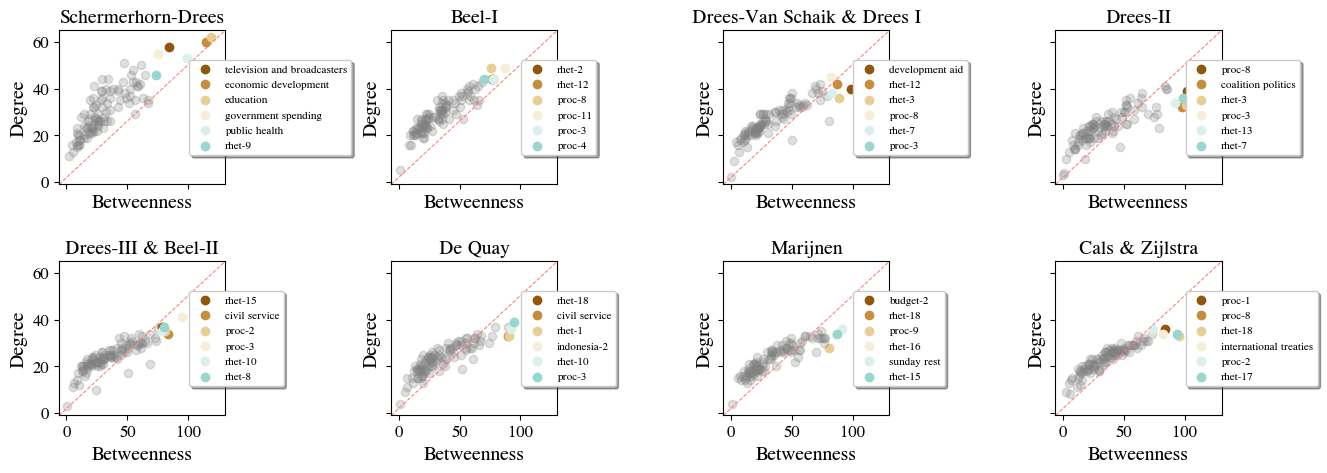

In [14]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

fig,axs = plt.subplots(2,4,figsize=(15,5),sharey=True,sharex=True)
axs = axs.flatten()

for c,(i,r) in enumerate(cab_.iterrows()):
    mask = (dists.index > r['startdate']) & (dists.index <= r['enddate'])
    theta = dists.loc[mask].to_numpy()
    theta,_,__ = mutual_information(theta)

    g,cmty,fmx = get_network_from_mi_theta(theta,thr=0)
    btw_vals = dict(get_betweenness_values(g))
    deg_vals = dict(get_degree_values(g))

    top_btw = [k for k,v in Counter(btw_vals).most_common(6)]
    top_deg = [k for k,v in Counter(btw_vals).most_common(6)]
    top = set(top_btw + top_deg)

    xmin,xmax = axs[c].get_xlim()
    ymin,ymax = axs[c].get_ylim()

    top_pal = sns.color_palette('BrBG',8)
    cc = 0
    for topic in deg_vals.keys():
        
        if topic in top:
            lab = labels[topic]
            axs[c].scatter([btw_vals[topic]],[deg_vals[topic]],color=top_pal[cc],alpha=1,label=lab)
            cc += 1
        if topic not in top:
            axs[c].scatter([btw_vals[topic]],[deg_vals[topic]],alpha=.25,color='grey')

    axs[c].set_title(r['cabinet'],fontsize=14)
    axs[c].set_ylabel('Degree')
    axs[c].set_xlabel('Betweenness')
    axs[c].legend(loc='center left', bbox_to_anchor=(.75, 0.5),ncol=1, fancybox=True, shadow=True,fontsize=8)

    line = mlines.Line2D([0, 1], [0, 1], color='salmon',linewidth=.75,linestyle='--')
    transform = axs[c].transAxes
    line.set_transform(transform)
    axs[c].add_line(line)   

plt.subplots_adjust(hspace=.5,wspace=1)
# plt.savefig('figs/networks-cabinets-betweenness-degree.pdf',dpi=250)
plt.show()

# Calculate Diachronic Betweenness / Degree for Topics

In [69]:
# Define a normalization function
min_max_scaler = preprocessing.MinMaxScaler()

def mm_scaler(a):
    return np.squeeze(np.asarray(min_max_scaler.fit_transform(np.array(a).reshape(-1,1))))

In [39]:
# Create a DF with the mean topic prominence per quarter
dg = dists.groupby(dists.index.to_period('Q')).mean()

In [40]:
# Loop over quarters, get networks (with a dis_filter of .75) and extract per-node betweenness and degree
r = []
for c,(date,dist_subset) in enumerate(dists.groupby(dists.index.to_period('Q'))):
    g,comm,edge_df = get_network_from_mi_theta(mi_theta=dist_subset.to_numpy(),weight_threshold=0,dis_filter=.75,labels=labels,node_text='labels')
    btw = dict(get_betweenness_values(g))
    deg = dict(get_degree_values(g))
    r += [{"top":l,"btw":btw[l],"deg":deg[l],"date":date} for l in btw]
rd = pd.DataFrame(r)

/home/rb/Documents/GitHub/linkage/helpers/networks.py:176: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:177: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("score_min", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:178: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("variance_max", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:176: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  table = table.drop("edge", 1)
/home/rb/Documents/GitHub/linkage/helpers/networks.py:177: FutureWarning: In a future version o

In [95]:
# For the per-node degree and betweenness scores, calculate the zscores for their time series

rd_btw = rd.drop(columns='deg').pivot(index='date',columns='top',values='btw').fillna(0.0)
rd_btw = pd.DataFrame(np.apply_along_axis(zscore,0,rd_btw),index=rd_btw.index,columns=rd_btw.columns)

rd_deg = rd.drop(columns='btw').pivot(index='date',columns='top',values='deg').fillna(0.0)
rd_deg = pd.DataFrame(np.apply_along_axis(zscore,0,rd_deg),index=rd_deg.index,columns=rd_deg.columns)

In [104]:
# Combine the degree and betweennes time series, extract their max z-score
# This gives a crude overview of the most "bursty" topics 

top_pol = rd_deg.max().reset_index()
top_pol = pd.merge(top_pol,rd_btw.max().reset_index(),on='top',how='outer')
top_pol.columns = ['topic','deg_stand_max','btw_stand_max']

In [113]:
# Sort on betweenness
# If chosen ascending=True, the least bursty topics are visible, which are mostly rhetorical and procedural topics, which makes sense (they are not suddenly politicized)
top_pol.sort_values('btw_stand_max',ascending=False).head(15)

,topic,deg_stand_max,btw_stand_max
37,land consolidation,7.393488,8.775899
47,pbo,6.712577,8.726428
66,public insurances,6.123921,8.543265
27,government spending,6.558743,8.521185
13,credit markets,6.639146,8.390580
0,agricultural prices,6.327406,8.388965
90,social work,4.075041,8.288765
38,lower education,5.376914,8.034732
18,education,6.234818,7.896254
56,proc-13,7.030886,7.812193


In [130]:
def plot_pol(topic_label):
    test_rd = rd.query(f'top == "{topic_label}"').drop(columns='top').set_index('date')
    test_rd['topic_prominence'] = dg[[k for k,v in labels.items() if v == f'{topic_label}'][0]]
    test_rd = test_rd[['deg','btw','topic_prominence']].apply(mm_scaler)
    # test_rd = test_rd.rolling(5).mean()
    test_rd.plot(cmap='Dark2',subplots=True,figsize=(4,5))

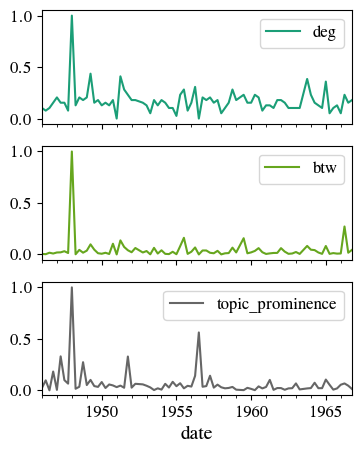

In [131]:
plot_pol('credit markets')